# Contaminant Transport

````{note}
This page is generated from an `*.ipynb` file which requires several auxiliary files, all of which can be downloaded using the link below.
```{eval-rst}
:download:`Download zip file for this exercise.<exercise_contamination.zip>`
```
````

The purpose of this exercise is to:
- evaluate component reliability
- illustrate functions of random variables
- see the effect of random variable distributions on reliability
- consider 'sensitivity' as a functional and/or stochastic influence on the limit-state function

You should accomplish this by playing with the code that is provided with the notebook and trying to answer the following questions:
1. Which random variables have the biggest influence on reliability?
2. How does the assumption of probability distribution influence reliability?
3. Do the random variables act as loads or resistances?

## Introduction of Case Study

The case study is a contaminant transport problem, illustrated in the figure below. A factory located near a town produces hazardous waste, which can threaten the drinking water supply of the town that is extracted from groundwater wells (C). The regional groundwater system has a gradient that causes water to flow in the direction of the town from the factory, thus any spilled hazardous waste that enters the ground will eventually be transported to the wells. In order to mitigate the consequences of a spill a ditch is constructed around the factory to collect it (A). Unfortunately, even with powerful pumps, there will still be some waste that reaches the groundwater table. Our task is to quantify the probability that the waste concentration exceeds the maximum exposure level to prevent the drinking water becoming unhealthy.

```{figure} ./figures/sketch.png
---
width: 600px
name: sketch_contaminant
---

```

### Contaminant Transport

Once the ditch becomes contaminated it is cleaned quickly, but unfortunately a 'pulse' of contamination enters the ground, after which the regional gradient carries it towards the town (advection). The pulse also disperses due to diffusion, which results in a classic advection-diffusion problem (see red shapes in diagram, at three different times, $t$). Because the ditch extends a long distance in the lateral direction and the contaminant is buoyant (it floats on the groundwater table and we neglect vertical dispersion), the problem can be analyzed in 1 dimension with the following analytic expression:

$$
\frac{C}{C_0} = \frac{1}{2} \mathrm{erf}\left(\frac{x-(q/n)t}{2\sqrt{a(q/n)t}}\right)
$$

Where $C$ contaminant concentration (e.g., parts per million, ppm) at distance $x$ from the ditch at time $t$ after the spill, and $C_0$ is the concentration in the ditch (just prior to cleanup). $\mathrm{erf}$ is the error function. There are three parameters in the equation which are related to soil properties and groundwater flow:

- $q$ is the horizontal groundwater flow velocity (specific discharge) [m/day]
- $n$ is the soil porosity [$-$]
- $a$ is the longitudinal dispersivity, which describes dispersion in the left to right direction in the image [m]

Unfortunately there is not a lot of soil information, so we have to take into account uncertainty in these three variables, using the following probability distributions with first and second moments (i.e., $\mu$ and $\sigma$).

- $q\sim\mathrm{N}\left(\mu_q=1.00,\sigma_q=0.10\right)$
- $n\sim\mathrm{N}\left(\mu_n=0.20,\sigma_n=0.02\right)$
- $a\sim\mathrm{N}\left(\mu_a=10.0,\sigma_a=1.00\right)$

It is important to check the sensitivity of the reliability analysis to the distribution type and moments. We will use the concentration ratio $C/C_0$ to evaluate this problem and compare it to a threshold defined by health regulations: $\mathrm{threshold}=1e-4$.

### Definition of Limit States

As shown in the figure above, there are two locations of interest: the monitoring station ($x=100$ m from the ditch, point B) and the town well ($x=500$ m, point C). We are interested in evaluating two cases with a reliability analysis:
1. Whether the contamination can be detected at the monitoring station above the threshold level within 1 week of the spill, and 
2. If the contamination level at the town groundwater well exceeds the threshold level within 1 month of the spill (30 days)

Relating these descriptions to our variables of interest:
1. find the probability that $C/C_0$ > threshold 
2. find the probability that $C/C_0$ < threshold

We will refer to these values as 'failure probabilities', even though case 1 technically doesn't correspond to failure---it's just the way we refer to things in practice.

Next we will convert these into functions that will allow us to quantify the 'failure' conditions. For convenience, it is often useful to define the limit state as a function, $Z$, such that failure occurs when $Z<0$. It follows from the descriptions above, that the limit state functions for both cases are:

1. $Z=C/C_0 - \mathrm{threshold}$
2. $Z=\mathrm{threshold} - C/C_0$

NB: *in the book another notation used for $Z$ is $g_X(X)$.*

### Analysis Approach

Our programming task is to create a function of random variables to represent these two limit-states, define the random variables, then evaluate the reliability with Monte Carlo simulation. In other words, we will numerically approximate the probability distribution of $Z$, then evaluate reliability as $P(Z<0)$.

This is a lot of work, but fortunately a number of helper functions and a Class are provided in the auxiliary file `exercise_setup.py`!

### References

This example draws inspiration from Case 2 of the paper by {cite:t}`sitar1987`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy import stats
import seaborn as sns

from exercise_setup import process_negative_values
from exercise_setup import RandomVariableDistribution
from exercise_setup import pdf_of_function_of_RV
from exercise_setup import monte_carlo

## Defining the Limit States

We only define limit state Case 2 below, and will use a simple multiplying factor of $-1$ to switch to Case 1 using a multiplying factor `flip_LSF`.

In [2]:
def C_C0(q, n, a, x, t):
    """Contaminant concentration ratio."""
    q, n, a = process_negative_values(q, n, a)
    return 0.5*erfc((x - q/n*t)/(2*np.sqrt(a*(q/n)*t)))

def limit_state_fun(q, n, a, x, t, threshold):
    """Limit state fxn, Case 2 (multiply by flip_LSF=-1 for Case 1)."""
    return threshold - C_C0(q, n, a, x, t)

## Class `RandomVariableDistribution`

The class `RandomVariableDistribution` makes it very easy to define Normal and Lognormal distributions for the random variables. See documentation and example below.

NB: *you can use the code in `exercisesetup.py` and this notebook to confirm the result of the 2 random variable case in the Probabilistic Design chapter, and recreate the figures.*

In [3]:
print(RandomVariableDistribution.__doc__)

Define a N or LN probability to use in MUDE week 2.7 exercise.
    
    Usage:
    -----
    Create an instance of the class
        by default, the random variable is ~N(0,1)
    Specify distribution using 1st and 2nd moments for N or LN:
        --> use method define_distribution to change it!
             (the method prints a summary of the change)
        for example, copy/paste the following:
            test = RandomVariableDistribution()
            test.print_status()
            test.define_distribution(mean=5, stddev=1, dist_type='LN')
    An instance will include the following attributes:
        - distribution moment and (scipy) parameters shape, location, scale
        - dist_object: distribution object (scipy.stats)
        - get_sample: method for getting random samples from the distribution
        - plot_pdf_or_cdf:
    


The mean is 5.000e+00
The standard deviation is 1.000e+00
The distribution is Lognormal


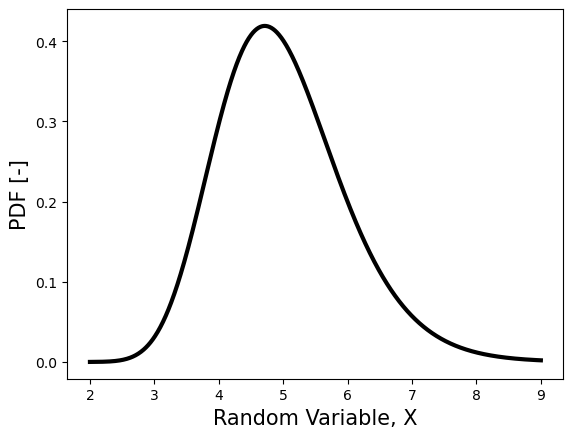

In [4]:
example_random_variable = RandomVariableDistribution()
example_random_variable.define_distribution(mean=5,
                                            dist_type='LN',
                                            print_new_dist=True)
example_random_variable.plot_pdf_or_cdf()

## Setting up the problem



In [5]:
N = 10000

t = 7
x = 100
threshold = 1e-4

flip_LSF = -1

q_rv = RandomVariableDistribution()
q_rv.define_distribution(mean=1., stddev=.1)
n_rv = RandomVariableDistribution()
n_rv.define_distribution(mean=0.2, stddev=.02)
a_rv = RandomVariableDistribution()
a_rv.define_distribution(mean=10., stddev=1.)

## Monte Carlo analysis

The Monte Carlo procedure for estimating failure probability, $p_f$, is:
- For each random variable $X_i$ ($i = 1, …, n$) one simulates N realizations, $x_{i,1}, x_{i,1}, ..., x_{i,N}$. 
- For each set of simulations $j$ ($j = 1, ..., N$) one calculates $g(x_{1,j}, x_{2,j}, …, x_{n,j})$
- In case $g(.) < 0$ a counter $N_f$ is increased by one. After $N$ simulations one calculates: $\hat{p_f}=N_f/N$
- In case $N\rightarrow+\infty$ one obtains the failure probability $p_f$.

The number of simulations $N$ directly influences the accuracy of $\hat{p_f}$, which is an estimate of the 'true' value $p_f$. As an infinite number of simulations is not possible, one must choose a value for $N$ that balances total computation time, which increases linearly with $N$, and accuracy of the estimator $\hat{p_f}$, which can be determined as the number of significant digits desired for $p_f$, or based on relative error (coefficient of variation, $V=\sigma/\mu$. The failure observations, $N_f$, within the Monte Carlo procedure are the result of a sequence of statistically independent and identically distributed random trials in a Bernoulli process. Using the binomial distribution, the standard deviation of of $\hat{p_f}$ can be written

$$\sigma_\hat{p_f}=\sqrt{\frac{p_f(1-p_f)}{N}}$$

As $\hat{p_f}\rightarrow1$ this leads to the coefficient of variation, $V_\hat{p_f}$:

$$V_\hat{p_f}=\frac{\sigma_\hat{p_f}}{\hat{p_f}}=\frac{1}{\sqrt{N\hat{p_f}}}$$

The coefficient of variation is a useful measure for gauging the accuracy of a Monte Carlo simulation: values of 0.01 are ideal, but 0.1 can be sufficient in many applications, depending on the need for accuracy. For example, consider $V=0.1$ for a target failure probability of $0.01$. Assuming the samples follow a Gaussian distribution implies a probability of 0.997 that the 'true' failure probability is within the interval 0.007-0.013. It is also useful to plot the calculated values of $V$ and $\hat{p_f}$ for every realization $j = 1, ..., N$, as shown below. The figure clearly shows convergence to a stable value of $\hat{p_f}$ after X simulations, indicating that for future analyses that are similar can use a lower number of simulations instead ($N\sim X$).

In case of a target coefficient of variation the number of required simulations $N$ increases as $p_f$ decreases. As an example, for $V = 0.01$ and $p_f=1e-5$ one has to execute $10^9$ simulations. As for this case on average only one of 10^5 simulations leads to an increase of $N_f$, the frequency of obtaining a 'success' (realization in the unsafe domain) is very low. In addition, for low failure probabilities the number of function evaluations is quite high, which may be practically impossible if there is a high function evaluation time, for example with a complex finite element model. To address this problem, variance reducing techniques have been developed which allow the simulations to be performed in a more effective way. In the following the so-called importance sampling or Latin hypercube sampling.

MONTE CARLO RESULTS
--------------------------------------------------
    N = 10000, number of samples
   Nf = 18, number of failed realizations
   pf = 1.800e-03, estimated failure probability
    V = 0.236, c.o.v. of estimated pf



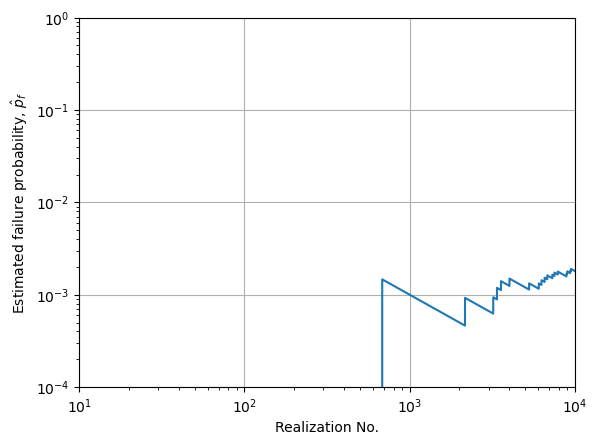

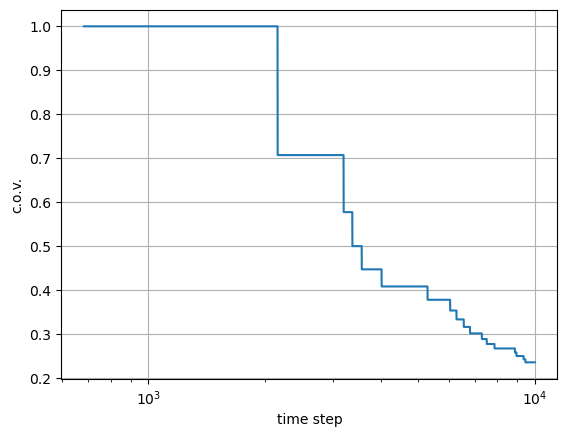

In [6]:
sample_q = q_rv.get_sample(N)
sample_n = n_rv.get_sample(N)
sample_a = a_rv.get_sample(N)
sample_C_C0 = C_C0(sample_q, sample_n, sample_a, x, t)
sample_Z = flip_LSF*limit_state_fun(sample_q,
                                    sample_n,
                                    sample_a,
                                    x, t, threshold)

monte_carlo(sample_Z);

The method `pdf_of_function_of_RV` makes it easy to see what the distribution of $C/C_0$ and the limit state function for different distributions of q, n or a. Below a second distribution of a is considered:

a has 61 negative values that have been set to 1.0e-03.
a has 54 negative values that have been set to 1.0e-03.
The mean is 1.000e+01
The standard deviation is 1.000e+00
The distribution is Normal
The mean is 1.000e+01
The standard deviation is 4.000e+00
The distribution is Normal


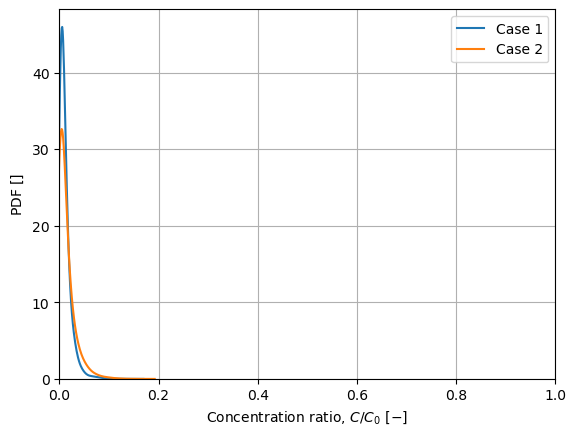

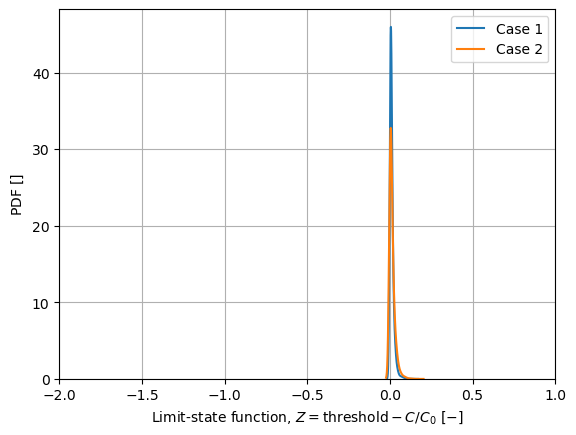

In [7]:
C_C0_cases = []
Z_cases = []
C_C0_cases.append(sample_C_C0)
Z_cases.append(sample_Z)

a_2 = RandomVariableDistribution()
a_2.define_distribution(mean=10, stddev=4, dist_type='N')
C_C0_cases.append(C_C0(sample_q, sample_n, a_2.get_sample(N), x, t))
Z_cases.append(flip_LSF*limit_state_fun(sample_q,
                                        sample_n,
                                        a_2.get_sample(N),
                                        x, t, threshold))

a_rv.print_status()
a_2.print_status()

pdf_of_function_of_RV(C_C0_cases)
pdf_of_function_of_RV(Z_cases, case_C=False)

This is the density of the function of random variables, $C/C_0$, two values of $\sigma_a$, and a third with the uniform distribution (not using the `RandomVariableDistribution` class).

Joint density of 2 RVs with failure realizations


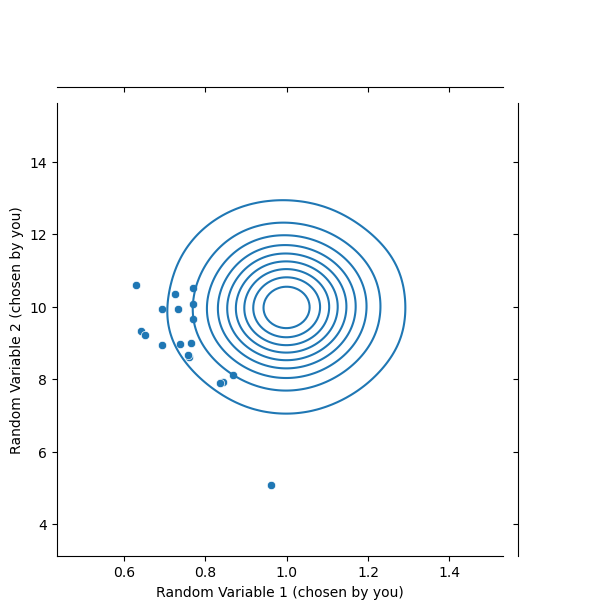

In [8]:
values_of_RV_1 = sample_q
values_of_RV_2 = sample_a

g = sns.JointGrid()
sns.kdeplot(x=values_of_RV_1,
            y=values_of_RV_2, ax=g.ax_joint, bw_adjust=3)
sns.scatterplot(x=values_of_RV_1[sample_Z<0],
                y=values_of_RV_2[sample_Z<0], ax=g.ax_joint)
g.ax_joint.set_xlabel('Random Variable 1 (chosen by you)')
g.ax_joint.set_ylabel('Random Variable 2 (chosen by you)')
print('Joint density of 2 RVs with failure realizations')

## Case 2: exceeding the health threshold

Now we return to the failure definition of exceeding the threshold (`flip_LSF` = 1).

MONTE CARLO RESULTS
--------------------------------------------------
    N = 100000, number of samples
   Nf = 65, number of failed realizations
   pf = 6.500e-04, estimated failure probability
    V = 0.124, c.o.v. of estimated pf



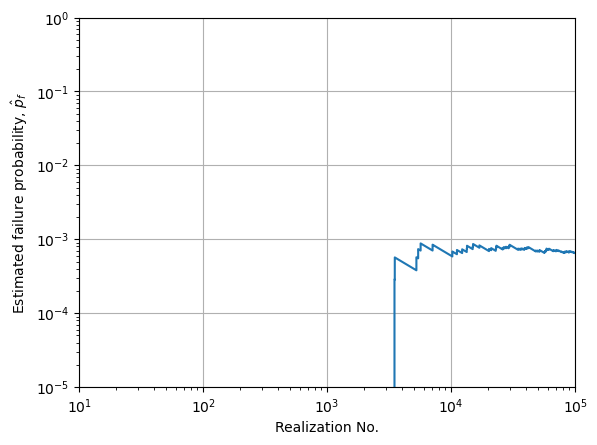

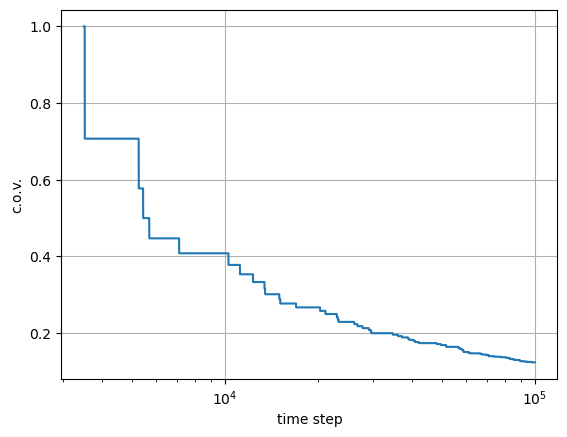

In [9]:
N = 100000

t = 30
x = 500
threshold = 1e-4

flip_LSF = 1

sample_q = q_rv.get_sample(N)
sample_n = n_rv.get_sample(N)
sample_a = a_rv.get_sample(N)

sample_C_C0 = C_C0(sample_q, sample_n, sample_a, x, t)
sample_Z = flip_LSF*limit_state_fun(sample_q,
                                    sample_n,
                                    sample_a,
                                    x, t, threshold)

monte_carlo(sample_Z);

NB: *the joint density and failure point plot is commented out here to prevent slowing down the kernel. When N=100000 (1e5) or higher, it will take around a minute to run.*

In [10]:
# values_of_RV_1 = sample_q
# values_of_RV_2 = sample_a

# g = sns.JointGrid()
# sns.kdeplot(x=values_of_RV_1,
#             y=values_of_RV_2, ax=g.ax_joint, bw_adjust=3)
# sns.scatterplot(x=values_of_RV_1[sample_Z<0],
#                 y=values_of_RV_2[sample_Z<0], ax=g.ax_joint)
# g.ax_joint.set_xlabel('Random Variable 1 (chosen by you)')
# g.ax_joint.set_ylabel('Random Variable 2 (chosen by you)')
# print('Joint density of 2 RVs with failure realizations')

### Gradient Vector

Partial derivatives will be useful for evaluating the functional influence of the variables on the limit states. The gradient vector is defined as:

$\nabla_{\mathbf{y}} G(\mathbf{y})=\left(\frac{\partial G(\mathbf{y})}{\partial \mathbf{y}_1}, \cdots, \frac{\partial G(\mathbf{y})}{\partial \mathbf{y}_n}\right) $

To find the gradient vector we need to find the partial derivatives of $\frac{C}{C_0}$

$\frac{C}{C_0} = \frac{1}{2} \mathrm{erfc}\left(\frac{x-(q/n)t}{2\sqrt{a(q/n)t}}\right)=\frac{1}{2} \left(1-\mathrm{erf}\frac{x-(q/n)t}{2\sqrt{a(q/n)t}}\right)$

Using $\frac{\partial}{\partial x} (\mathrm{erf} x) = \frac{2}{\sqrt{\pi}}e^{-x^2} $ and $\Omega = \frac{1}{\sqrt{\pi}}e^{-\left(\frac{x-(q/n)t}{2\sqrt{a(q/n)t}}\right)^2}  $, the derivatives are:

$\frac{\partial (C/C_0)}{\partial x} = \Omega\left(-\frac{1}{2\sqrt{a(q/n)t}}\right)$

$\frac{\partial (C/C_0)}{\partial t} =\Omega\left(\frac{x}{4\sqrt{a(q/n)t^3}}+\frac{q}{4n\sqrt{a(q/n)t}}\right)$

$\frac{\partial (C/C_0)}{\partial q} = \Omega\left(\frac{x}{4\sqrt{a(1/n)tq^3}}+\frac{t}{4n\sqrt{a(q/n)t}}\right)$

$\frac{\partial (C/C_0)}{\partial n} = \Omega\left(-\frac{x}{4\sqrt{aqtn}}-\frac{qt}{4\sqrt{qatn^3}}\right)$

$\frac{\partial (C/C_0)}{\partial a} = \Omega\left(\frac{x-q/nt}{4\sqrt{(q/n)ta^3}}\right)$

In [11]:
def gradient(q, n, a, x, t):
    Om = 1/np.sqrt(np.pi)*np.exp(-((x - q/n*t)/(2*np.sqrt(a*q/n*t)))**2)
    dx = Om*(-1/(2*np.sqrt(a*q/n*t)))
    dt = Om*(x/(4*np.sqrt(a*q/n*t**3)) + (q)/(4*n*np.sqrt(a*q/n*t)))
    dq = Om*(x/(4*np.sqrt(a*q**3/n*t)) + (t)/(4*n*np.sqrt(a*q/n*t)))
    dn = Om*(-x/(4*np.sqrt(a*q*n*t)) - (q*t)/(4*np.sqrt(a*q*n**3*t)))
    da = Om*((x - q/n*t)/(4*np.sqrt(a**3 *q/n*t)))
    return np.array([dq,dn,da,dx,dt])

In [12]:
print(gradient(2.5, 0.2, 10, x, t))

[ 2.84464056e-01 -3.55580070e+00  1.01594306e-02 -1.62550889e-03
  2.37053380e-02]


## Your turn!

Now try and use the code to answer the questions posed at the beginning of the notebook, which are repeated here:
1. Which random variables have the biggest influence on reliability?
2. How does the assumption of probability distribution influence reliability?
3. Do the random variables act as loads or resistances?

In particular, to evaluate sensitivity, you can consider two quantitative aspects:
1. What is the functional influence of the random variables and x and t on the limit-state function?
2. What is the stochastic influence of the random variables, 
3. What is the combined influence of the two aspects above?

<!--  
Hint: note the striking similarity of these terms to the material you have already seen in the variance propagation part of MUDE, where the variance of a function of random variables is proportional to $\sigma_x\cdot \frac{\partial Z}{\partial x}$. The variable with the biggest influence on reliability will have the highest value of this term. Also, the sign of the partial derivative will indicate whether a variable acts as a load or resistance. -->